### Working on real data set

###### Artificial Neural network

In [2]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import math
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import accuracy_score


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
try:
    df=pd.read_csv('drive/MyDrive/Datasets/NYCTaxiFares.csv')
except:
    df=pd.read_csv('Datasets/NYCTaxiFares.csv')

In [5]:
df.columns


Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [6]:
df=df.dropna()

In [7]:
df.isnull().sum()

pickup_datetime      0
fare_amount          0
fare_class           0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 7.3+ MB


In [9]:
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   pickup_datetime    120000 non-null  datetime64[ns, UTC]
 1   fare_amount        120000 non-null  float64            
 2   fare_class         120000 non-null  int64              
 3   pickup_longitude   120000 non-null  float64            
 4   pickup_latitude    120000 non-null  float64            
 5   dropoff_longitude  120000 non-null  float64            
 6   dropoff_latitude   120000 non-null  float64            
 7   passenger_count    120000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(2)
memory usage: 7.3 MB


######## only Haversine for is 100% generated by LLM - due to Formula

In [11]:
def haversine(row):
    # Extract latitude and longitude values from the row
    lat1, lon1, lat2, lon2 = row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']

    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.asin(math.sqrt(a))

    # Radius of Earth in kilometers. Use 3956 for miles
    r = 6371

    # Calculate the result
    distance = c * r
    return distance

In [12]:
df['distance km']=df.apply(haversine,axis=1)

In [13]:
def time_slot(hour):
    if 0 <= hour < 2:
        return 'Midnight (00-02)'
    elif 2 <= hour < 4:
        return 'Early Morning (02-04)'
    elif 4 <= hour < 6:
        return 'Early Morning (04-06)'
    elif 6 <= hour < 8:
        return 'Morning (06-08)'
    elif 8 <= hour < 10:
        return 'Morning (08-10)'
    elif 10 <= hour < 12:
        return 'Late Morning (10-12)'
    elif 12 <= hour < 14:
        return 'Afternoon (12-14)'
    elif 14 <= hour < 16:
        return 'Afternoon (14-16)'
    elif 16 <= hour < 18:
        return 'Evening (16-18)'
    elif 18 <= hour < 20:
        return 'Evening (18-20)'
    elif 20 <= hour < 22:
        return 'Night (20-22)'
    else:
        return 'Late Night (22-24)'

In [14]:
df['time_intervel']=df['pickup_datetime'].dt.hour.apply(time_slot)

In [15]:
peaktime=df['pickup_datetime'].groupby(df['time_intervel']).count().sort_values()
peaktime

time_intervel
Early Morning (04-06)     3337
Early Morning (02-04)     5130
Morning (06-08)           7520
Midnight (00-02)          8237
Late Morning (10-12)     10769
Evening (16-18)          11130
Morning (08-10)          11304
Afternoon (12-14)        11496
Afternoon (14-16)        11777
Late Night (22-24)       12010
Night (20-22)            13218
Evening (18-20)          14072
Name: pickup_datetime, dtype: int64

In [16]:
dict ={
    'Early Morning (04-06)':'minimum',
    'Early Morning (02-04)':'minimum',
    'Morning (06-08)':'medium',
    'Midnight (00-02)':'medium',
    'Evening (16-18)':'maximum',
    'Late Morning (10-12)':'maximum',
    'Morning (08-10)':'maximum',
    'Afternoon (14-16)':'maximum',
    'Afternoon (12-14)':'maximum',
    'Late Night (22-24)':'maximum',
    'Night (20-22)':'peak',
    'Evening (18-20)':'peak'


}

In [17]:
df['Time_decision']=df['time_intervel'].map(dict)

In [18]:
df['Time_decision'].value_counts()

Time_decision
maximum    68486
peak       27290
medium     15757
minimum     8467
Name: count, dtype: int64

In [19]:
df['Day']=df['pickup_datetime'].dt.day_name()

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   pickup_datetime    120000 non-null  datetime64[ns, UTC]
 1   fare_amount        120000 non-null  float64            
 2   fare_class         120000 non-null  int64              
 3   pickup_longitude   120000 non-null  float64            
 4   pickup_latitude    120000 non-null  float64            
 5   dropoff_longitude  120000 non-null  float64            
 6   dropoff_latitude   120000 non-null  float64            
 7   passenger_count    120000 non-null  int64              
 8   distance km        120000 non-null  float64            
 9   time_intervel      120000 non-null  object             
 10  Time_decision      120000 non-null  object             
 11  Day                120000 non-null  object             
dtypes: datetime64[ns, UTC](1), flo

In [21]:
df['time_intervel'] = df['time_intervel'].astype('category')
df['Day'] = df['Day'].astype('category')
df['Time_decision'] = df['Time_decision'].astype('category')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   pickup_datetime    120000 non-null  datetime64[ns, UTC]
 1   fare_amount        120000 non-null  float64            
 2   fare_class         120000 non-null  int64              
 3   pickup_longitude   120000 non-null  float64            
 4   pickup_latitude    120000 non-null  float64            
 5   dropoff_longitude  120000 non-null  float64            
 6   dropoff_latitude   120000 non-null  float64            
 7   passenger_count    120000 non-null  int64              
 8   distance km        120000 non-null  float64            
 9   time_intervel      120000 non-null  category           
 10  Time_decision      120000 non-null  category           
 11  Day                120000 non-null  category           
dtypes: category(3), datetime64[ns,

In [23]:
df['Month']=df['pickup_datetime'].dt.month_name()

In [24]:
df['Month'] = df['Month'].astype('category')

In [25]:
df['Month'].value_counts().mean(),df['Day'].value_counts().mean()

(120000.0, 17142.85714285714)

In [26]:
df

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance km,time_intervel,Time_decision,Day,Month
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,Morning (08-10),maximum,Monday,April
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,Afternoon (14-16),maximum,Saturday,April
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,Late Morning (10-12),maximum,Saturday,April
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,Night (20-22),peak,Sunday,April
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,Early Morning (02-04),minimum,Saturday,April
...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,2010-04-18 14:33:03+00:00,15.3,1,-73.955857,40.784590,-73.981941,40.736789,1,5.751348,Afternoon (14-16),maximum,Sunday,April
119996,2010-04-23 10:27:48+00:00,15.3,1,-73.996329,40.772727,-74.049890,40.740413,1,5.767444,Late Morning (10-12),maximum,Friday,April
119997,2010-04-18 18:50:40+00:00,12.5,1,-73.988574,40.749772,-74.011541,40.707799,3,5.052523,Evening (18-20),peak,Sunday,April
119998,2010-04-13 08:14:44+00:00,4.9,0,-74.004449,40.724529,-73.992697,40.730765,1,1.208923,Morning (08-10),maximum,Tuesday,April


In [27]:
y=df['fare_amount'].values

In [28]:
cont=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count','distance km']


In [29]:
continious = df[cont].values

In [30]:
cat = ['time_intervel','Time_decision','Day','Month']

In [31]:
time_interval=df['time_intervel'].cat.codes.values
time_decision=df['Time_decision'].cat.codes.values
day=df['Day'].cat.codes.values
month=df['Month'].cat.codes.values

In [32]:
catergories = np.stack([time_interval,time_decision,day,month],axis=1)

In [33]:
catergories

array([[10,  0,  1,  0],
       [ 1,  0,  2,  0],
       [ 6,  0,  2,  0],
       ...,
       [ 5,  3,  3,  0],
       [10,  0,  5,  0],
       [ 4,  0,  2,  0]], dtype=int8)

In [34]:
catergories = torch.tensor(catergories,dtype=torch.int64).to(device)

In [35]:
continious= torch.tensor(continious , dtype=torch.float).to(device)

In [36]:
catergories

tensor([[10,  0,  1,  0],
        [ 1,  0,  2,  0],
        [ 6,  0,  2,  0],
        ...,
        [ 5,  3,  3,  0],
        [10,  0,  5,  0],
        [ 4,  0,  2,  0]], device='cuda:0')

In [37]:
continious

tensor([[-73.9924,  40.7305, -73.9755,  40.7447,   1.0000,   2.1263],
        [-73.9901,  40.7406, -73.9742,  40.7441,   1.0000,   1.3923],
        [-73.9941,  40.7511, -73.9601,  40.7662,   2.0000,   3.3268],
        ...,
        [-73.9886,  40.7498, -74.0115,  40.7078,   3.0000,   5.0525],
        [-74.0044,  40.7245, -73.9927,  40.7308,   1.0000,   1.2089],
        [-73.9554,  40.7719, -73.9676,  40.7630,   3.0000,   1.4274]],
       device='cuda:0')

In [38]:
y=torch.tensor(y,dtype=torch.float).reshape(-1,1).to(device)

In [39]:
y

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        ...,
        [12.5000],
        [ 4.9000],
        [ 5.3000]], device='cuda:0')

In [40]:
catergories.shape

torch.Size([120000, 4])

In [41]:
continious.shape

torch.Size([120000, 6])

In [42]:
### NN Embedding cat or work to numerical

In [43]:
catergories_sizes=[len(df[col].cat.categories) for col in cat]

In [44]:
catergories_sizes

[12, 4, 7, 1]

In [45]:
embedding_sizes=[(size,min(50,(size+1)//2)) for size in catergories_sizes]

In [46]:
embedding_sizes

[(12, 6), (4, 2), (7, 4), (1, 1)]

In [47]:
cat_slice=catergories[:4]

In [48]:
cat_slice

tensor([[10,  0,  1,  0],
        [ 1,  0,  2,  0],
        [ 6,  0,  2,  0],
        [11,  3,  3,  0]], device='cuda:0')

In [49]:
selfembeds=nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in embedding_sizes]).to(device)

In [50]:
selfembeds

ModuleList(
  (0): Embedding(12, 6)
  (1): Embedding(4, 2)
  (2): Embedding(7, 4)
  (3): Embedding(1, 1)
)

In [51]:
embedding = []
for i,e in enumerate(selfembeds):
    embedding.append(e(cat_slice[:,i]))

In [52]:
embedding

[tensor([[-8.4230e-01, -3.3110e-01,  1.3265e+00, -6.8780e-01, -9.7306e-01,
           4.1921e-01],
         [ 1.4531e+00,  2.3882e+00,  9.7832e-01,  1.3746e+00,  6.2300e-01,
          -8.5020e-01],
         [-4.0981e-01, -1.1320e+00,  1.3180e+00, -1.0017e+00,  6.6897e-01,
           2.3099e-03],
         [-1.6435e+00,  2.7203e-01,  9.3454e-01,  8.2804e-01,  1.0285e+00,
           3.9494e-01]], device='cuda:0', grad_fn=<EmbeddingBackward0>),
 tensor([[-0.7890, -2.3636],
         [-0.7890, -2.3636],
         [-0.7890, -2.3636],
         [-0.3521, -2.6781]], device='cuda:0', grad_fn=<EmbeddingBackward0>),
 tensor([[-0.6653, -0.7347, -0.2535, -0.2993],
         [-1.3177,  0.1881,  0.3623, -0.0460],
         [-1.3177,  0.1881,  0.3623, -0.0460],
         [ 0.7045, -0.0469,  0.8054, -0.7864]], device='cuda:0',
        grad_fn=<EmbeddingBackward0>),
 tensor([[0.8053],
         [0.8053],
         [0.8053],
         [0.8053]], device='cuda:0', grad_fn=<EmbeddingBackward0>)]

In [53]:
z=torch.cat(embedding,1) #concat along dim1

In [54]:
z

tensor([[-8.4230e-01, -3.3110e-01,  1.3265e+00, -6.8780e-01, -9.7306e-01,
          4.1921e-01, -7.8898e-01, -2.3636e+00, -6.6529e-01, -7.3466e-01,
         -2.5348e-01, -2.9934e-01,  8.0534e-01],
        [ 1.4531e+00,  2.3882e+00,  9.7832e-01,  1.3746e+00,  6.2300e-01,
         -8.5020e-01, -7.8898e-01, -2.3636e+00, -1.3177e+00,  1.8814e-01,
          3.6232e-01, -4.6034e-02,  8.0534e-01],
        [-4.0981e-01, -1.1320e+00,  1.3180e+00, -1.0017e+00,  6.6897e-01,
          2.3099e-03, -7.8898e-01, -2.3636e+00, -1.3177e+00,  1.8814e-01,
          3.6232e-01, -4.6034e-02,  8.0534e-01],
        [-1.6435e+00,  2.7203e-01,  9.3454e-01,  8.2804e-01,  1.0285e+00,
          3.9494e-01, -3.5211e-01, -2.6781e+00,  7.0453e-01, -4.6904e-02,
          8.0536e-01, -7.8643e-01,  8.0534e-01]], device='cuda:0',
       grad_fn=<CatBackward0>)

In [55]:
delfembdrop=nn.Dropout(p=0.3)

In [56]:
z=delfembdrop(z)

In [57]:
z

tensor([[-1.2033, -0.0000,  1.8950, -0.9826, -1.3901,  0.5989, -1.1271, -0.0000,
         -0.9504, -1.0495, -0.3621, -0.4276,  0.0000],
        [ 2.0758,  3.4118,  0.0000,  1.9638,  0.8900, -1.2146, -1.1271, -3.3765,
         -1.8825,  0.2688,  0.5176, -0.0000,  1.1505],
        [-0.5854, -0.0000,  1.8829, -0.0000,  0.9557,  0.0000, -1.1271, -3.3765,
         -0.0000,  0.2688,  0.0000, -0.0658,  1.1505],
        [-2.3479,  0.3886,  1.3351,  1.1829,  1.4693,  0.5642, -0.5030, -3.8258,
          1.0065, -0.0670,  1.1505, -1.1235,  1.1505]], device='cuda:0',
       grad_fn=<NativeDropoutBackward0>)

In [58]:
class Model_v2(nn.Module):
    def __init__(self,embedding_sizes,num_continious,out_features,Layers,dropout_probablity=0.3):
        super().__init__()

        self.embeds_list = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_sizes])
        self.emb_drop = nn.Dropout(dropout_probablity)
        self.bn_norm = nn.BatchNorm1d(num_continious)

        layerlist = []
        sum_embedding_sizes=sum([nf for ni,nf in embedding_sizes])
        num_infeatures=num_continious+sum_embedding_sizes

        for i in Layers:
          layerlist.append(nn.Linear(num_infeatures,i))
          layerlist.append(nn.ReLU(inplace=True))
          layerlist.append(nn.BatchNorm1d(i))
          layerlist.append(nn.Dropout(dropout_probablity))
          num_infeatures = i

        layerlist.append(nn.Linear(Layers[-1],out_features))

        self.layers = nn.Sequential(*layerlist)


    def forward(self,x_Category,X_continious):
        embedding = []
        for i,e in enumerate(self.embeds_list):
            embedding.append(e(x_Category[:,i]))

        x= torch.cat(embedding,1)
        x=self.emb_drop(x)
        x_continious=self.bn_norm(X_continious)
        x=torch.cat([x,x_continious],1)
        x=self.layers(x)
        return x


In [59]:
torch.manual_seed(42)
model_v1=Model_v2(embedding_sizes,6,1,[1024, 512, 256, 128,64,32,16,4]
).to(device)

In [60]:
model_v1.parameters

<bound method Module.parameters of Model_v2(
  (embeds_list): ModuleList(
    (0): Embedding(12, 6)
    (1): Embedding(4, 2)
    (2): Embedding(7, 4)
    (3): Embedding(1, 1)
  )
  (emb_drop): Dropout(p=0.3, inplace=False)
  (bn_norm): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=19, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): ReLU(inplace=True)
    (14): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.3, inplace=False)
    (16): Linear(in_features=128, out_features=64, bias=True)
    (17): ReLU(inplace=True)
    (18): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (19): Dropout(p=0.3, inplace=False)
    (20): Linear(in_features=64, out_features=32, bias=True)
    (21): ReLU(inplace=True)
    (22): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (23): Dropout(p=0.3, inplace=False)
    (24): Linear(in_features=32, out_features=16, bias=True)
    (25): ReLU(inplace=True)
    (26): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (27): Dropout(p=0.3, inplace=False)
    (28): Linear(in_features=16, out_features=4, bias=True)
    (29): ReLU(inplace=True)
    (30): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (31): Dropout(p=0.3, inplace=False)
    (32): Linear(in_features=4, out_features=1, bias=True)
  )
)>

In [61]:
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model_v1.parameters(),lr=0.1)

In [62]:
X_train_continious, X_test_continious, y_train, y_test=train_test_split(continious,y,test_size=0.2,random_state=33)

In [63]:
X_train_catergories, X_test_catergories, y_train, y_test=train_test_split(catergories,y,test_size=0.2,random_state=33)


In [64]:
cat_con_train=TensorDataset(X_train_continious,X_train_catergories,y_train)

In [65]:
Dataload=DataLoader(cat_con_train,batch_size=10000,shuffle=True)

### Model_training

In [66]:
start_time=time.time()
losses=[]
Epochs=150
loss=torch.tensor(0)
for i in range(Epochs):
      model_v1.train()
      for continious,catergories,train in Dataload:
          y_pred=model_v1.forward(catergories,continious)
          loss = torch.sqrt(criterion(y_pred,train))
          optimizer.zero_grad()
          losses.append(loss.item())
          loss.backward()
          optimizer.step()

      print(f'Epoch {i} , on last batch  ,loss - {loss.item()}')
      i=i+1
end_time=time.time()
print(f'training time - {(end_time-start_time)/60 } - Minutes')

Epoch 0 , on last batch  ,loss - 7.7192511558532715
Epoch 1 , on last batch  ,loss - 5.488769054412842
Epoch 2 , on last batch  ,loss - 5.154524803161621
Epoch 3 , on last batch  ,loss - 4.994110107421875
Epoch 4 , on last batch  ,loss - 4.742630481719971
Epoch 5 , on last batch  ,loss - 4.652924537658691
Epoch 6 , on last batch  ,loss - 4.360207557678223
Epoch 7 , on last batch  ,loss - 4.343032360076904
Epoch 8 , on last batch  ,loss - 4.284158706665039
Epoch 9 , on last batch  ,loss - 4.223762035369873
Epoch 10 , on last batch  ,loss - 4.213934898376465
Epoch 11 , on last batch  ,loss - 4.215091705322266
Epoch 12 , on last batch  ,loss - 4.395078182220459
Epoch 13 , on last batch  ,loss - 4.189181804656982
Epoch 14 , on last batch  ,loss - 3.9182024002075195
Epoch 15 , on last batch  ,loss - 3.7758655548095703
Epoch 16 , on last batch  ,loss - 4.130562782287598
Epoch 17 , on last batch  ,loss - 3.945575475692749
Epoch 18 , on last batch  ,loss - 4.013094902038574
Epoch 19 , on last 

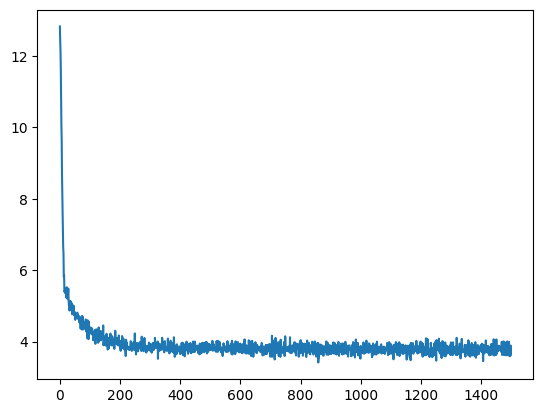

In [67]:
plt.plot([i for i in range(len(losses))],losses)

In [68]:
with torch.inference_mode():
  model_v1.eval()
  pred=model_v1(X_test_catergories,X_test_continious)
  loss_n=criterion(pred,y_test)

In [69]:
loss_n

tensor(10.3691, device='cuda:0')

In [70]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

In [71]:
pred

tensor([[ 6.4483],
        [11.0713],
        [ 9.9960],
        ...,
        [ 6.4327],
        [ 7.2912],
        [ 8.4379]], device='cuda:0')

In [72]:
y_test


tensor([[ 4.5000],
        [10.9000],
        [10.9000],
        ...,
        [ 6.9000],
        [ 7.7000],
        [ 6.9000]], device='cuda:0')

In [74]:
torch.save(model_v1.state_dict(),'drive/MyDrive/Datasets/Uber_newyork_weight_bias.pt')

In [73]:
model_v1.state_dict()

OrderedDict([('embeds_list.0.weight',
              tensor([[-0.1439,  0.7105,  0.9255, -0.9286,  1.3699, -0.4871],
                      [-0.0221,  1.2790,  1.7215, -0.2407,  1.2044, -0.4901],
                      [ 3.9545, -0.6354, -5.8294,  3.4566,  0.7678,  1.9741],
                      [-3.0592, -3.3356, -0.4518,  0.0064, -0.4322, -0.7322],
                      [ 0.1551,  1.0096,  1.2266, -0.2623,  0.7531, -0.1001],
                      [ 0.2839,  1.4921, -0.6566, -0.0606, -0.0529,  0.4865],
                      [-0.0104, -0.2471, -0.3318, -0.9458,  1.1643, -0.3366],
                      [-1.7294, -0.8354, -1.7783,  2.4890, -1.2836,  2.8034],
                      [-0.1103, -0.8038, -2.3384,  1.3531, -4.2673,  1.6813],
                      [-1.4955, -2.0467, -0.6443,  0.4832, -0.5823, -2.5237],
                      [ 2.7102, -0.6812, -0.3297, -2.1045, -0.1283, -0.4822],
                      [-1.1144, -0.1228, -0.9901,  1.4435, -0.8893,  1.7713]],
                     devi

In [75]:
torch.save(model_v1,'drive/MyDrive/Datasets/Uber_newyork_model.pt')

In [76]:
torch.save(Model_v2,'drive/MyDrive/Datasets/Uber_newyork_class.pt')

In [ ]:
torch.save(criter,'drive/MyDrive/Datasets/Uber_newyork_class.pt')